# YouTube Data API v3

In [2]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# api_key is stored in config.py
import config
import networkx as nx

import collections

### 1 - Youtube Search (query, n)
    Returns list of channel dictionaries
### 2 - Youtube Channel List
    Returns details on a specific channel
#### A - Request channel details (channelId)
    Returns a json dictionary for a specific channel Id
#### B - Run Channel List (list of channelIds)
    Returns a list of dictionaries per channel

Search method iterating using tokens to get more than 50 results. 

Uses requests to grab type=channel, part=snippet, order=?;

Creates an empty list, extends the list with the json's reponse items (50 at a time).

### Function to to return a list of maxResults parameter for each api request

 For a given number of requests and a specified batch_size, function will return a list of maxResults. 
 
 For example: (123, 50) returns [50,50,23]

In [3]:
def determine_max_result_list(n, batch_size):
    '''Function to return a list of max results parameters for a specific number of requests and batch_sizes.
    
    For example: (123,50) returns [50,50,23]'''
    # Logic to determine maxResults parameter
    if n%50 == 0:
        request_size_list = [batch_size]*(n//batch_size)
    # Determine a list of request sizes []
    else:
        request_size_list = [batch_size]*(n//batch_size) + [n%batch_size]
    return request_size_list

### Function to request a youtube search response for a given query and number of requests

Returns a list of dictionaries, each dictionary represents a specific channel and their subsequent details.<br>
Also create a channelid_list which comes from ```CHANNEL_LIST[0]['id']```

In [4]:
# Search for channels by a specific query
def request_youtube_search_channels(query, n):
    '''Returns a list of n channels that match the query.\n
    Uses /youtube/v3/search'''
    
    request_size_list = determine_max_result_list(n,50)
        
    # Empty list to store 50 items from each response
    channel_list = list()
    
    # Instantiate nextPageToken, when '' method interprets null
    nextPageToken = ''


    for request_size in request_size_list:
        
        # Create request object
        resp = requests.get(
            'https://www.googleapis.com/youtube/v3/search',
            params=dict(part='snippet', 
                        type='channel',
                        maxResults=request_size,
                        pageToken=nextPageToken,
                        q=query,
                        key=config.api_key)
        )
        assert resp.ok
        nextPageToken = json.loads(resp.content)['nextPageToken']
        channel_list.extend(json.loads(resp.content)['items'])
        #print(len(set(channel['id']['channelId'] for channel in channel_list)))
    return channel_list
#CHANNEL_LIST = request_youtube_search_channels('Minecraft',23)

# Extract Channel Ids from the list of dictionaries
#CHANNELID_LIST = [channel['snippet']['channelId'] for channel in CHANNEL_LIST]

### Function to request details on a list of channelIds

Returns a list of channel_resp json dictionaries stored in ```json.content['items']``` across all json responses (if requesting a list larger than 50)

In [5]:
# Get channel details and snippet
def request_channel_list(channelid_list):
    
    # Check for non-unique elements
    if len(channelid_list) != len(set(channelid_list)):
        print("There are non-unique elements in this list")
        
    # Determine request size list
    request_size_list = determine_max_result_list(len(set(channelid_list)),50)

    # Instantiate channel response list
    channel_resp_list = []
    
    # Set the start_index to 0
    start_index = 0
    # Loop 
    for request_size in request_size_list:
        
        # Debug
        #print(request_size_list, request_size, start_index, start_index+request_size)
        
        resp = requests.get(
            'https://www.googleapis.com/youtube/v3/channels',
            params=dict(part='contentDetails, snippet, statistics,\
                        brandingSettings, topicDetails, status, id, contentOwnerDetails',
                    id=channelid_list[start_index:start_index+request_size],
                    maxResults=50,
                    key=config.api_key)
        )
        # Increase the start_index
        start_index += request_size
        
        # Extend channel response list
        channel_resp_list.extend(json.loads(resp.content)['items'])
        
    return channel_resp_list
#CHANNEL_RESP = request_channel_list(CHANNELID_LIST)

### Function to flatten dictionary nesting of channel resp for dataframe format

Returns a list of dictionaries where each key in the dictionary maps to a column of interest.<br>
As input takes a list of dictionaries where each dictionary is a specific 'item' from the original json.

In [6]:
def extract_channel_details(channel_resp):
    # Instantite empty channels details list for new dictionary format
    channel_details_list = list()
    
    # Loop over each channel's json dictionary in details_list
    for channel in channel_resp:
        # Instantiate new details dictionary; in series update the dictionary to include relevant details
        channel_details_dict = {}
        channel_details_dict.update(dict(id=channel['id']))
        channel_details_dict.update(channel['snippet'])
        channel_details_dict.update(channel['contentDetails'])
        #channel_details_dict.update(channel['topicDetails'])
        channel_details_dict.update(channel['status'])
        channel_details_dict.update(channel['statistics'])
        channel_details_dict.update(channel['brandingSettings']['channel'])
        
        # Append the added channel's new dictionary format to channel details list
        channel_details_list.append(channel_details_dict)
    return channel_details_list

#CHANNEL_DETAILS_LIST = extract_channel_details(CHANNEL_RESP)

# Insert list of dictionaries into pandas dataframe
#df = pd.DataFrame(CHANNEL_DETAILS_LIST)

# Main

In [25]:
# Request n number of channels from a youtube search
CHANNEL_LIST = request_youtube_search_channels('Corridor Digital',20)

# Retrieve Channel Ids from the list of dictionaries
CHANNELID_LIST = [channel['snippet']['channelId'] for channel in CHANNEL_LIST]

# Request details from each channel
CHANNEL_RESP = request_channel_list(CHANNELID_LIST)

# Extract channel details to a list of dictionaries for pandas
CHANNEL_DETAILS_LIST = extract_channel_details(CHANNEL_RESP)

In [108]:
def extract_featured_channels(channel_response):
    ''' Function to extract a set of featured channelIds from a list of channelIds'''
    
    featured_channels_list = list()
    channels_wo_features_count = 0
    for channel in channel_response:

        if 'featuredChannelsUrls' in channel['brandingSettings']['channel']:
            featured_channels_list.extend(channel['brandingSettings']['channel']['featuredChannelsUrls'])
        else:
            channels_wo_features_count +=1
    print(f'{len(set(featured_channels_list))} neighbors; {channels_wo_features_count} out of {len(channel_response)} channels do not feature channels')
    return set(featured_channels_list)

In [109]:
FEATURED_CHANNELS_SET = extract_featured_channels(CHANNEL_RESP)
print(len(FEATURED_CHANNELS_SET))
    

48 neighbors; 6 out of 20 channels do not feature channels
48


# Exploring the data

In [67]:
def create_dataframe(channel_details_list):
    df = pd.DataFrame(channel_details_list)
    df['videoCount'] = df['videoCount'].map(lambda x: int(x))
    df['commentCount'] = df['commentCount'].map(lambda x: int(x))
    df['viewCount'] = df['viewCount'].map(lambda x: int(x))
    df['subscriberCount'] = df['subscriberCount'].map(lambda x: int(x))
    df['featuredChannelsCount'] = df['featuredChannelsUrls'].apply(lambda x: 0 if type(x) == float else len(x))
    return df

features = ['id','title','description','customUrl','publishedAt','country','isLinked', 'viewCount', 'commentCount', 'subscriberCount',
           'hiddenSubscriberCount','keywords','showRelatedChannels','featuredChannelsUrls', 'featuredChannelsCount']

DF = create_dataframe(CHANNEL_DETAILS_LIST)
DF.shape

(20, 29)

In [ ]:
DF.info()

In [ ]:
DF[features].sort_values(by='subscriberCount', ascending = False).head(5)

In [ ]:
sns.distplot(DF['subscriberCount'].map(lambda x: np.log(x+1)))

In [ ]:
sns.distplot(DF['viewCount'].map(lambda x: np.log(x+1)))

In [ ]:
plt.scatter(DF['subscriberCount'], DF['viewCount'])

In [ ]:
plt.barh(DF['title'], DF['subscriberCount'])

## NetworkX

In [32]:
# Dictionary comprehension to create channelId:featuredChannelUrls data structure
CHANNEL_NETWORK = {channel['id']:channel['featuredChannelsUrls'] if 'featuredChannelsUrls' in channel.keys() else [] for channel in CHANNEL_DETAILS_LIST}

# Dict Comp to create channelId:Channelname data structure
CHANNEL_NAMES = {channel['id']:channel['title'] if 'title' in channel.keys() else '' for channel in CHANNEL_DETAILS_LIST}

In [111]:
def graph_channels(channel_details_list):
    
    # Dictionary comprehension to create channelId:featuredChannelUrls data structure
    channel_network = {channel['id']:channel['featuredChannelsUrls'] \
                   if 'featuredChannelsUrls' in channel.keys() else [] \
                   for channel in channel_details_list}

    # Dict Comp to create channelId:Channelname data structure
    channel_names = {channel['id']:channel['title'] \
                 if 'title' in channel.keys() else '' \
                 for channel in channel_details_list}
    
    G = nx.DiGraph(channel_network)
    plt.figure(figsize = (12,12))
    nx.draw_networkx(G,
                 with_labels=True,
                 labels=CHANNEL_NAMES,
                 font_size=12, font_color = 'red')
    return G

In [33]:
def graph_channels(channel_network, channel_names):
    
    G = nx.DiGraph(channel_network)
    plt.figure(figsize = (12,12))
    nx.draw_networkx(G,
                 with_labels=True,
                 labels=CHANNEL_NAMES,
                 font_size=12, font_color = 'red')
    return G

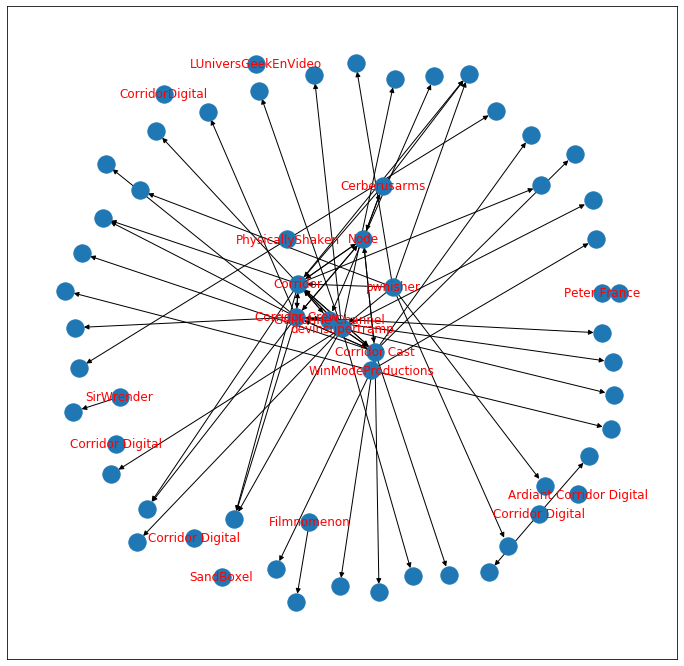

In [34]:
G = graph_channels(CHANNEL_NETWORK, CHANNEL_NAMES)

In [17]:
def simple_page_rank():
    A = nx.adjacency_matrix(G)
    n, _ = A.shape
    v0 = np.ones(n) / n
    for i in range(20):
        v1 = A @ v0
        v1 /= v1.sum(0)
        print(np.linalg.norm(v1 - v0))
        v0 = v1
    return v1

In [18]:
V1 = simple_page_rank()

0.4248506977509211
0.43958195302202935
0.03481467479566267
0.009203905826486183
0.0023859142860193335
0.0008083913691497646
0.00026817181188718204
8.941804784456635e-05
2.9462213260344412e-05
9.781372042336256e-06
3.348080676199306e-06
1.2028269660855013e-06
4.5274447172232506e-07
1.7503384208938552e-07
6.803464021051012e-08
2.6206248989753326e-08
9.929181058553926e-09
3.6882581476818037e-09
1.3414227607029809e-09
4.774468693742951e-10


In [20]:
CHANNELIDS = list(G.nodes().keys())
vector = pd.Series(data = V1, index = CHANNELIDS)
DF['v1'] = DF['id'].map(lambda x:vector[x])

In [23]:
len(CHANNELIDS)

222

In [21]:
DF[['title','id','subscriberCount','viewCount','v1','featuredChannelsCount']].sort_values('v1', ascending=False).head(20)

,title,id,subscriberCount,viewCount,v1,featuredChannelsCount
7,Node,UCI4Wh0EQPjGx2jJLjmTsFBQ,3260000,798198223,0.119455,6
24,Jake Watson,UCw8MVJS-EGwNj75hw_nz71A,1920,0,0.113762,4
8,Corridor,UCsn6cjffsvyOZCZxvGoJxGg,8060000,1461467298,0.113461,11
17,Corridor Crew,UCSpFnDQr88xCZ80N-X7t0nQ,4090000,703710166,0.113461,12
20,Corridor Cast,UCNSeDrWRGxx5p2l3tj7RWQw,110000,4980586,0.107768,10
25,Guillotine Channel,UCb8ewylk7d2M_1dLGEiFmuQ,224000,3051119,0.083839,3
49,Парни из коридора,UCQVkdC44At_R67DqRYvnFNQ,4940,7943,0.083839,3
15,Brett Driver,UCPW2c87kcpoCY7FeVjJW6Ow,41200,4135407,0.063963,4
1,Cerberusarms,UCylK-v3Fz4Zqjx6hGIbuDcg,249000,16395750,0.058345,3
10,Speak No Evil,UC30_i8K40q4qC_1tMAAZZNQ,6760,246891,0.056843,2


# Connected Components

In [22]:
import collections
def run():
    sizes = []
    ccs = []
    for cc in nx.connected_components(G.to_undirected()):
        ccs.append(cc)
        sizes.append(len(cc))
    print(sorted(sizes))
    return ccs#collections.Counter(sizes)

CCS = run()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 5, 5, 6, 7, 27, 133]


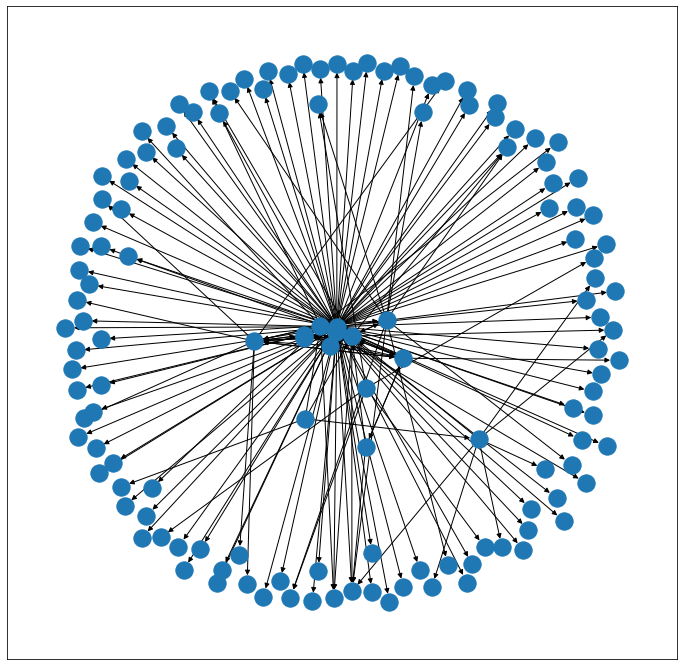

In [24]:
plt.figure(figsize = (12,12))
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)),
                 with_labels=False)
                 #labels=CHANNEL_NAMES,
                 #font_size=12, font_color = 'red')

In [ ]:
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)))